# Code description of Counter Trend strategy<a class="tocSkip">
    
This mean reversion style model will try to enter when trend models stop out, betting on the price moving up again. This strategy is taken from the book __Trading Evolved__ in chapter 17. This strategy is there described for trading with futures, however the necessary modifications have been done in order to implement the model for trading securities.

***

## Content

- Section 0 : the strategy
- Section 1 : libraries
- Section 2 : helper functions and model settings
- Section 3 : main functions (__initialize__, __daily_trade__)
- Section 4 : running backtest
- Section 5 : Pyfolio tear sheet

## The strategy

### Model purpose
If we had a nice bull market trend in the oil market for instance, it would reasonable to assume that most if not all trend followers are long. Now imagine that the price of oil starts to decline for whatever reason. At some point, trend followers start exit. And that can push the price a bit further down, perhaps even triggering stops for other trend followers.

Given the sheer size of trend following capital, this can create a situation where a small market correction is amplified by their stop loss orders. This could result in two things. First that the market is pushed further back than it otherwise would be. Second, that when trend followers are done stopping out, there could be a snap back, as the prices had been artificially depressed by the stops.

This model tries to exploit this phenomenon.

### Investment Universe
A more interesting way to see a mean reversion model like this, is as a portfolio component, traded alongside with trend following models.

### Trading Frequency
With this particular model, we trade daily.

### Position allocation
The position sizes taken for this model aim to take an equal amount of risk per position. For a given security, the total allocation is given by the following : 

$$ C = \frac{R P}{\sigma}, $$
where:
- $R =$ risk factor
- $P =$ portfolio value (marked to market)
- $\sigma =$ standard deviation of prices changes

__Important__: The value of sigma is based on the prices changes (the difference), and not on the percentage changes (quotient). The amount of days to consider is defined by the variable __vola_window__.

The value $RP$ represents the amount that we want our portfolio to change __at most__ by a single open position on an asset per day. If we divide this amount by $\sigma$ (which represents the average daily move of the asset) we basically obtain the number of shares that we are allowed to buy without surpassing our risk limits.

**Note**: To keep the logic simple here, no regular rebalancing of position sizes is done, nor is any more complex volatility targeting technique employed. Both of these make more sense for institutional portfolio management than for individual accounts.

### Trading Rules

We apply this model only to bull markets. While a similar approach can be implemented to bear rallies, different settings and even a different approach might prove more adequate.

For defining a bull market we need the variables : 
- `slow_ma` : for the slow exponential moving average (SEMA)
- `fast_ma` : for the fast exponential moving average (FEMA)

We thus have a bull market if FEMA > SEMA.

If the market is bull and the `pullback` is greater than `dip_buy`, we go long on the given asset.

The variable `pullback` tells us how many standard deviations we have moved down from the highest price in a period of `high_window` days:

`pullback = (current price - highest in period) / std`

We then exit the market if we it becomes bearish or if we hold the positions for more than `days_to_hold` days

### Zipline implementation
Recall that the usual zipline backtesting implementation requires the definition of 3 functions:
- __initialize__
- __handle_data__
- __analyze__

A variation of this implementation is done when implementing the Time Return strategy. For this, we define the function __daily_trade__, where all the trading logic is done.

We then make use of a particular function provided by the zipline API : __schedule_function__. It will help us call the  __daily_trade__ function on a daily basis.

## Libraries

In [1]:
'''
Zipline dependencies
'''
import zipline
from zipline.api import symbol, set_commission, set_slippage, \
    schedule_function, date_rules, set_benchmark, \
    time_rules, order_target
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

'''
Pyfolio dependency
'''
import pyfolio as pf

'''
Other dependencies
'''
%matplotlib notebook
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

## General settings

### Model settings

We first define the model settings. These will be used throughout the whole simulation in order to compute several values required to carry the trading strategy.

In [29]:
"""
Model Settings
"""
starting_portfolio = 100000
vola_window = 40
slow_ma = 10
fast_ma = 5
risk_factor = 0.015
high_window = 10
days_to_hold = 5
dip_buy = -1
benchmark_symbol = 'AAPL'

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.2
slippage_impact = 0.1

### Helper functions

We now define the helper functions

In [3]:
def position_size(portfolio_value, std, pv=1):
    '''
    Computes risk adjusted contract allocation as a function of volatility.
    
    Args : 
        portfolio_value (float) = total portfolio value marked to market
        std (float) = standard deviation of a given asset
        point_value = size of contract (for equities is 1, for futures it depends on the underlying)
    
    Returns : 
        int = number of contracts to buy 
    
    Raises :
        -
    
    Notes :
        The portfolio is marked to market at each call
    '''
    
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts))

## Main functions

### Initialize

In [5]:
def initialize(context):
    """
    Cost Settings
    """
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
        
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, \
                                           price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)      
        
    set_slippage(slippage_model)
    
    """
    Markets to trade
    """ 
    markets = [
        "AAPL"
    ]
    
    # Set benchmark
    set_benchmark(symbol(benchmark_symbol))
    
    # Make a list of all continuations
    context.universe = [ symbol(market) for market in markets ]

    
    # Dictionary used for keeping track of how many days a position has been open.
    context.bars_held = {market : 0 for market in context.universe} 
    
    # Schedule daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

### Daily trade

In [10]:
def daily_trade(context, data):
    # Get the history
    hist = data.history(
        context.universe, 
        fields=['close', 'volume'], 
        frequency='1d', 
        bar_count=250,
    )
    
    # Calculate the trend
    hist['trend'] = hist['close'].ewm(span=fast_ma).mean() > hist['close'].ewm(span=slow_ma).mean()
    
    # Loop all markets
    for market in context.universe:
        
        # Slice off history for this market
        h = hist.xs(market, 2)
        
        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()
        
        if market in context.portfolio.positions: # Position is already open
            context.bars_held[market] += 1 # One more day held
            
            if context.bars_held[market] >= 20:
                # Held for a month, exit
                order_target(market, 0)

            elif h['trend'].iloc[-1] == False:
                # Trend changed, exit.
                order_target(market, 0)
        
        else:   # No position open yet.   
            if h['trend'].iloc[-1]:
                
                # Calculate the pullback
                pullback = (
                    h['close'].values[-1] - np.max(h['close'].values[-high_window:])
                    ) / std
                
                if pullback < dip_buy:
                    # Calculate size
                    contracts_to_trade = position_size(context.portfolio.portfolio_value, std)                  
                    # Trade
                    order_target(market, contracts_to_trade)
                    
                    # Reset bar count to zero
                    context.bars_held[market] = 0

## Running backtest

In [30]:
'''
Selecting dates
'''
start = datetime(2010, 1, 1, 8, 15, 12, 0, pytz.UTC)
end = datetime(2011, 1, 2, 8, 15, 12, 0, pytz.UTC)

'''
Running backtest
'''
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    capital_base=starting_portfolio,  
    data_frequency = 'daily', 
    bundle='quandl' )

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


## Pyfolio tear sheet

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


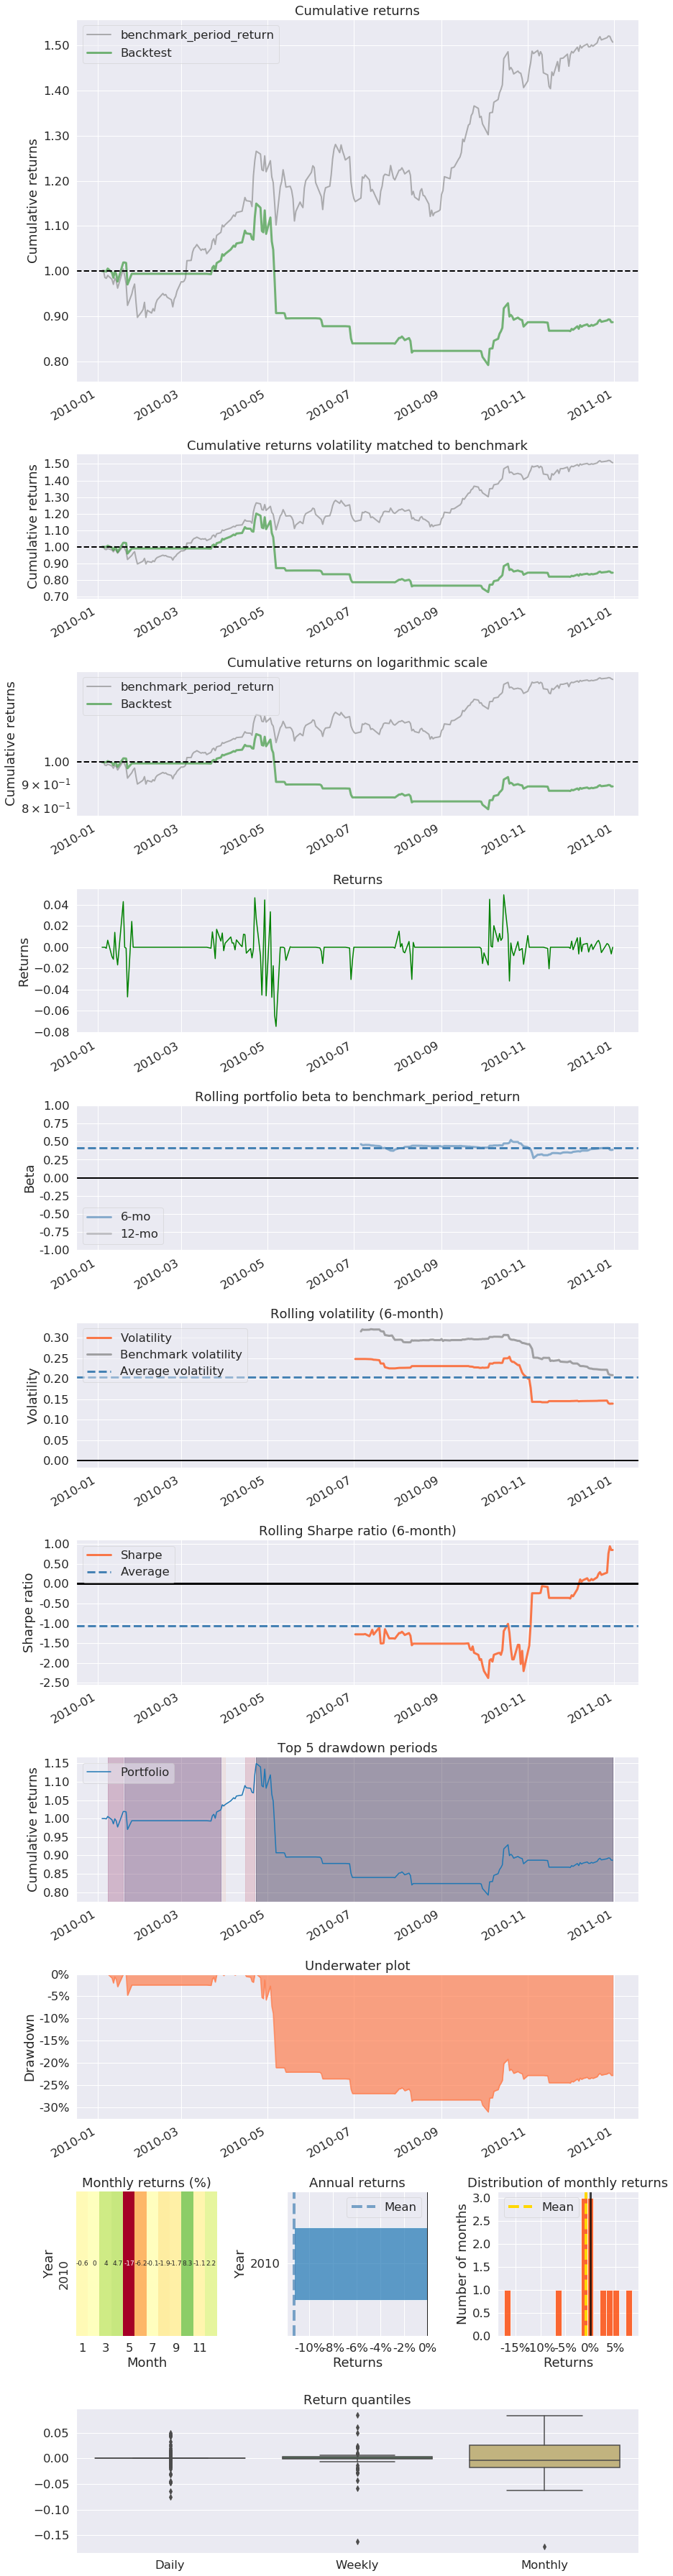

In [31]:
%matplotlib inline
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']
# Convert benchmark returns to daily returns
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
pf.create_returns_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)